In [44]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import openpyxl


#加载构建CNN网络的包
from tensorflow.keras.layers import Dense,RNN,LSTM,Activation,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.decomposition import PCA
import collections
from itertools import cycle
from scipy import interp

from sklearn.metrics import classification_report, accuracy_score,auc,confusion_matrix,precision_score,recall_score,roc_auc_score,\
roc_curve,f1_score
from sklearn import metrics
import pickle
import json
import os
import warnings
warnings.filterwarnings('ignore')

In [45]:
files = os.listdir('拉曼数据')
# data0 = pd.read_table('拉曼数据/'+'4-1-1.txt',header=None)
# dat = np.zeros((len(files),data0.shape[0],data0.shape[1]))
# for i in range(len(files)):
#     data0 = pd.read_table('拉曼数据/'+files[i],header=None)
#     dat[i,:,:] = data0.values
# dat = dat.reshape((dat.shape[0],dat.shape[1],dat.shape[2],1))
# dat.shape

In [46]:
#定义绘制CNN模型训练过程准确率和损失率的函数
def plot1(history,file=''):
    acc = history.history['mse']#训练集的准确率
    val_acc = history.history['val_mse']#验证集的准确率
    loss = history.history['loss']#训练集的过程损失
    val_loss = history.history['val_loss']#验证集的过程损失
    
    epochs = range(1, len(acc) + 1)#迭代次数
    
    #下面分别画出图并保存
    plt.plot(epochs, acc, 'r', label='Training mse')
    plt.plot(epochs, val_acc, 'b', label='Validation mse')
    plt.title('Training and Validation mse')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    # plt.savefig(file+'Training and Validation mse.png',bbox='tight')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    # plt.savefig(file+'Training and Validation loss.png',bbox='tight')
    plt.show()

In [47]:
# data.head(10)
data=pd.read_excel("newlabel.xlsx",index_col='序号',header=0)
data.head()

DSS       AWS      MDXS      DFSB        Sc
序号                                                     
4-1-1  0.047086  0.031652  0.105118  2.054229  3.503772
4-1-2  0.052025  0.009681  0.112967  2.177835  3.919927
4-1-3  0.056221  0.029940  0.116185  2.251329  3.998878
4-1-4  0.059036  0.035721  0.118939  2.298153  4.159827
4-1-5  0.062070  0.045199  0.121587  2.320460  4.189648

In [48]:
y = pd.DataFrame()
y['序号'] = [i[:-4] for i in files]
y = pd.merge(y,data,on='序号')
y.head()

序号       DSS       AWS      MDXS      DFSB        Sc
0    4-3-5  0.015248  0.019573  0.041200  0.353162  0.547090
1    5-1-9  0.066873  0.047632  0.101852  2.249556  4.035370
2  10-2-12  0.046783  0.046933  0.088517  1.049943  1.705180
3   7-1-10  0.075014  0.058107  0.134353  2.624427  4.572640
4  10-3-14  0.019749  0.023162  0.052460  0.404599  0.674889

In [49]:
res = pd.DataFrame(np.zeros((y.shape[1]-1,4)),index=y.columns[1:],columns=['tain r2','test r2','tain RMSE','test RMSE'])

In [50]:
res.index

Index(['DSS', 'AWS', 'MDXS', 'DFSB', 'Sc'], dtype='object')

In [69]:
def plotrealpred(yc,ycp,yv,yvp):
    plt.figure(figsize=(5, 5), dpi=120)
    
    plt.scatter(yc, ycp, s=5, c='r', marker='o',alpha=0.8)
    plt.scatter(yv, yvp, s=5, c='b', marker='s',alpha=0.8)
    plt.legend(["train",'test'])
    plt.plot([-10,10],[-10,10])
    plt.xlabel('Measured mg/mL')
    plt.ylabel('Predicted mg/mL')
    plt.xlim(min(yc)-0.02, max(yc)+0.02)
    plt.ylim(min(yc)-0.02, max(yc)+0.02)    
    # plt.tight_layout(pad=0.3)
    # plt.grid(True)
    return plt

import random

def plottime(yc,ycp,yv,yvp):
    pass
    # return plt

In [52]:
df=pd.read_excel("x_y_new.xlsx",index_col='name',header=0)
# df.head()
x=df.iloc[:,:-5]
DSS=df['DSS/mg/ml']
AWS=df['AWS/mg/ml']
MDXS=df['MDXS/mg/ml']
DFSB=df['DFSB/mg/ml']
Sc=df['Sc/%']
# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x),columns=x.columns,index=x.index)

In [53]:
res

tain r2  test r2  tain RMSE  test RMSE
DSS       0.0      0.0        0.0        0.0
AWS       0.0      0.0        0.0        0.0
MDXS      0.0      0.0        0.0        0.0
DFSB      0.0      0.0        0.0        0.0
Sc        0.0      0.0        0.0        0.0

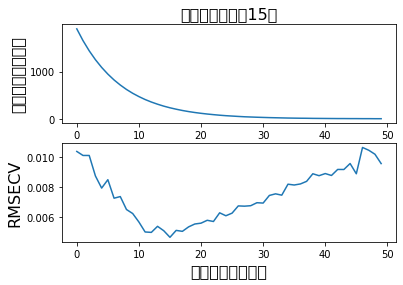

((260, 232, 2, 1), (65, 232, 2, 1), (260, 1), (65, 1))

In [54]:
import CARS
lis = CARS.CARS_Cloud(np.array(x), np.array(DSS))
x=np.array(x)
x_=x[:,lis]
x_train, x_test, y_train, y_test = train_test_split(x_, np.array(DSS), test_size=0.2, random_state=45)
x_train_=np.expand_dims(x_train,2).repeat(2,axis=2)
x_train_=np.expand_dims(x_train_,3)
x_train=x_train_
x_test_=np.expand_dims(x_test,2).repeat(2,axis=2)
x_test_=np.expand_dims(x_test_,3)
x_test=x_test_
y_train_=np.expand_dims(y_train,1)
y_train=y_train_
y_test_=np.expand_dims(y_test,1)
y_test=y_test_
x_train.shape,x_test.shape,y_train.shape,y_test.shape,

In [70]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_dim=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 1), activation='relu'))
model_cnn.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
print(model_cnn.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 353, 2, 32)        128       
                                                                 
 batch_normalization_20 (Bat  (None, 353, 2, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 176, 2, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_146 (Conv2D)         (None, 174, 2, 16)        1552      
                                                                 
 conv2d_147 (Conv2D)         (None, 172, 2, 16)        784       
                                                                 
 conv2d_148 (Conv2D)         (None, 170, 2, 16)      

Epoch 1/200
6/6 [==============================] - 1s 81ms/step - loss: 1.4864 - mse: 1.4864 - val_loss: 78.0157 - val_mse: 78.0157
Epoch 2/200
6/6 [==============================] - 0s 52ms/step - loss: 0.6347 - mse: 0.6347 - val_loss: 39.1705 - val_mse: 39.1705
Epoch 3/200
6/6 [==============================] - 0s 46ms/step - loss: 0.4252 - mse: 0.4252 - val_loss: 10.0052 - val_mse: 10.0052
Epoch 4/200
6/6 [==============================] - 0s 49ms/step - loss: 0.4436 - mse: 0.4436 - val_loss: 5.4583 - val_mse: 5.4583
Epoch 5/200
6/6 [==============================] - 0s 48ms/step - loss: 0.4309 - mse: 0.4309 - val_loss: 5.7402 - val_mse: 5.7402
Epoch 6/200
6/6 [==============================] - 0s 48ms/step - loss: 0.3825 - mse: 0.3825 - val_loss: 4.7508 - val_mse: 4.7508
Epoch 7/200
6/6 [==============================] - 0s 48ms/step - loss: 0.4011 - mse: 0.4011 - val_loss: 3.0343 - val_mse: 3.0343
Epoch 8/200
6/6 [==============================] - 0s 52ms/step - loss: 0.4130 - mse

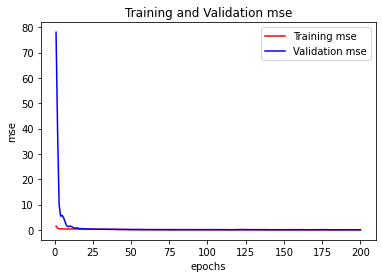

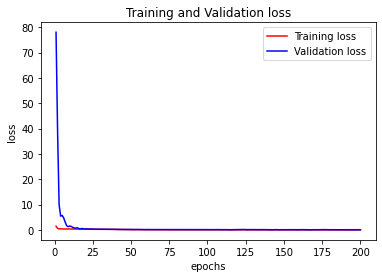

3/3 [==============================] - 0s 6ms/step


ValueError: Unrecognized marker style 'c'

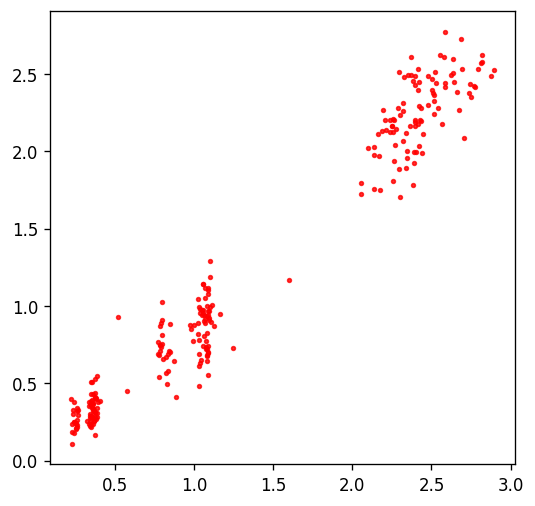

In [71]:
c = 'DSS'
  
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_dim=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 1), activation='relu'))
model_cnn.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=40, verbose=1), # 当patience次迭代损失未改善，Keras停止训练
                ]
history_cnn = model_cnn.fit(x_train,y_train,batch_size=50,epochs=200,validation_data=(x_test, y_test),verbose=1,callbacks=callbacks)
model_cnn.save(c+"___"+"cnn.h5")
print(metrics.r2_score(y_test,model_cnn.predict(x_test)))
res.loc[c,'test r2'] = metrics.r2_score(y_test,model_cnn.predict(x_test))
res.loc[c,'tain r2'] = metrics.r2_score(y_train,model_cnn.predict(x_train))
res.loc[c,'test RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_test),y_test))
res.loc[c,'tain RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_train),y_train))
    
plot1(history_cnn,file=c+'______')

y_predictions = model_cnn.predict(x_train)
y_predictions_p = model_cnn.predict(x_test)
plotrealpred(y_train,y_predictions,y_test,y_predictions_p)
plottime(y_train,y_predictions,y_test,y_predictions_p)

In [57]:
res

tain r2   test r2  tain RMSE  test RMSE
DSS   0.95603  0.836161   0.004923   0.009645
AWS   0.00000  0.000000   0.000000   0.000000
MDXS  0.00000  0.000000   0.000000   0.000000
DFSB  0.00000  0.000000   0.000000   0.000000
Sc    0.00000  0.000000   0.000000   0.000000

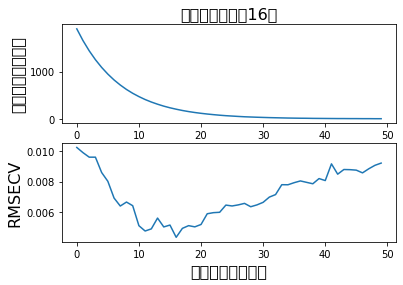

((260, 202, 2, 1), (65, 202, 2, 1), (260, 1), (65, 1))

In [58]:
test_size = 0.2
random_state = 1

c = 'AWS'

import CARS
lis = CARS.CARS_Cloud(np.array(x), np.array(AWS))
x=np.array(x)
x_=x[:,lis]
x_train, x_test, y_train, y_test = train_test_split(x_, np.array(AWS), test_size=0.2, random_state=45)
x_train_=np.expand_dims(x_train,2).repeat(2,axis=2)
x_train_=np.expand_dims(x_train_,3)
x_train=x_train_
x_test_=np.expand_dims(x_test,2).repeat(2,axis=2)
x_test_=np.expand_dims(x_test_,3)
x_test=x_test_
y_train_=np.expand_dims(y_train,1)
y_train=y_train_
y_test_=np.expand_dims(y_test,1)
y_test=y_test_
x_train.shape,x_test.shape,y_train.shape,y_test.shape,
    
    


Epoch 1/200
26/26 [==============================] - 3s 55ms/step - loss: 4.5537e-04 - mse: 4.5537e-04 - val_loss: 7.6986e-04 - val_mse: 7.6986e-04
Epoch 2/200
26/26 [==============================] - 1s 37ms/step - loss: 1.4685e-04 - mse: 1.4685e-04 - val_loss: 3.6830e-04 - val_mse: 3.6830e-04
Epoch 3/200
26/26 [==============================] - 1s 37ms/step - loss: 1.5182e-04 - mse: 1.5182e-04 - val_loss: 1.5297e-04 - val_mse: 1.5297e-04
Epoch 4/200
26/26 [==============================] - 1s 42ms/step - loss: 1.4474e-04 - mse: 1.4474e-04 - val_loss: 2.0578e-04 - val_mse: 2.0578e-04
Epoch 5/200
26/26 [==============================] - 1s 37ms/step - loss: 1.7315e-04 - mse: 1.7315e-04 - val_loss: 1.0562e-04 - val_mse: 1.0562e-04
Epoch 6/200
26/26 [==============================] - 1s 37ms/step - loss: 1.4935e-04 - mse: 1.4935e-04 - val_loss: 9.0877e-05 - val_mse: 9.0877e-05
Epoch 7/200
26/26 [==============================] - 1s 38ms/step - loss: 1.3231e-04 - mse: 1.3231e-04 - val_los

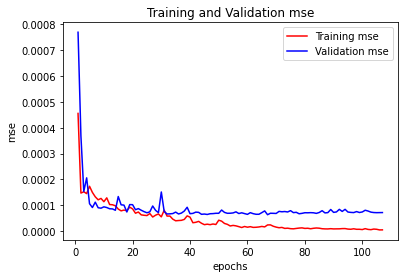

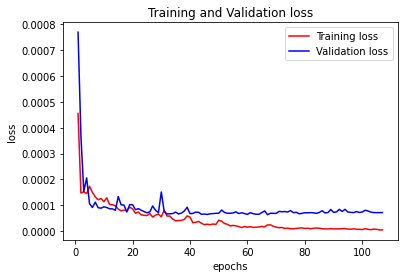

3/3 [==============================] - 0s 9ms/step


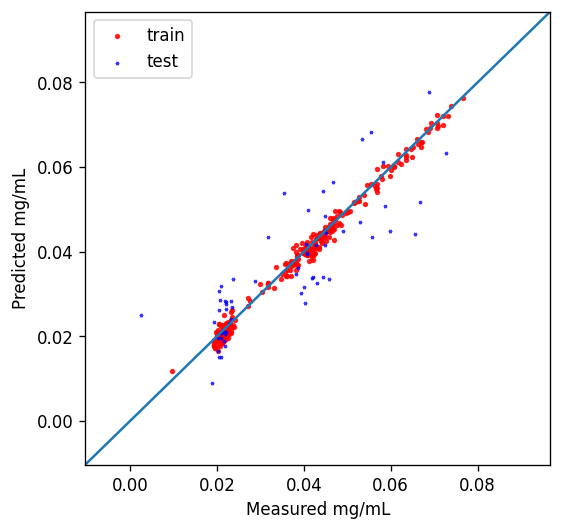

In [59]:
model_cnn = Sequential()
model_cnn.add(Conv2D(64, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_shape=(x_train.shape[1],x_train.shape[2],1)))
#model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 1), activation='relu'))
model_cnn.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=40, verbose=1), # 当patience次迭代损失未改善，Keras停止训练
                ]
history_cnn = model_cnn.fit(x_train,y_train,batch_size=10,epochs=200,validation_data=(x_test, y_test),verbose=1,callbacks=callbacks)
model_cnn.save(c+"___"+"cnn.h5")
print(metrics.r2_score(y_test,model_cnn.predict(x_test)))

c='AWS'
res.loc[c,'test r2'] = metrics.r2_score(y_test,model_cnn.predict(x_test))
res.loc[c,'tain r2'] = metrics.r2_score(y_train,model_cnn.predict(x_train))
res.loc[c,'test RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_test),y_test))
res.loc[c,'tain RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_train),y_train))
    
plot1(history_cnn,file=c+'______')

y_predictions = model_cnn.predict(x_train)
y_predictions_p = model_cnn.predict(x_test)
plotrealpred(y_train,y_predictions,y_test,y_predictions_p)
plottime(y_train,y_predictions,y_test,y_predictions_p)

In [60]:
res

tain r2   test r2  tain RMSE  test RMSE
DSS   0.956030  0.836161   0.004923   0.009645
AWS   0.989654  0.700521   0.001518   0.008445
MDXS  0.000000  0.000000   0.000000   0.000000
DFSB  0.000000  0.000000   0.000000   0.000000
Sc    0.000000  0.000000   0.000000   0.000000

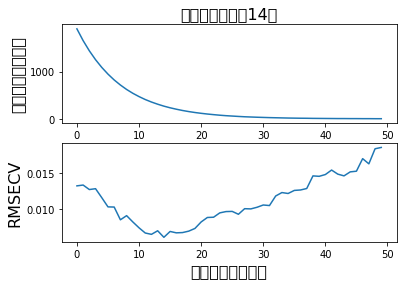

((260, 268, 2, 1), (65, 268, 2, 1), (260, 1), (65, 1))

In [61]:
test_size = 0.2
random_state = 1

c = 'MDXS'

import CARS
lis = CARS.CARS_Cloud(np.array(x), np.array(MDXS))
x=np.array(x)
x_=x[:,lis]
x_train, x_test, y_train, y_test = train_test_split(x_, np.array(MDXS), test_size=0.2, random_state=45)
x_train_=np.expand_dims(x_train,2).repeat(2,axis=2)
x_train_=np.expand_dims(x_train_,3)
x_train=x_train_
x_test_=np.expand_dims(x_test,2).repeat(2,axis=2)
x_test_=np.expand_dims(x_test_,3)
x_test=x_test_
y_train_=np.expand_dims(y_train,1)
y_train=y_train_
y_test_=np.expand_dims(y_test,1)
y_test=y_test_
x_train.shape,x_test.shape,y_train.shape,y_test.shape,
    


Epoch 1/200
6/6 [==============================] - 2s 135ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0802 - val_mse: 0.0802
Epoch 2/200
6/6 [==============================] - 0s 53ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 3/200
6/6 [==============================] - 0s 57ms/step - loss: 7.9668e-04 - mse: 7.9668e-04 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/200
6/6 [==============================] - 0s 48ms/step - loss: 7.7872e-04 - mse: 7.7872e-04 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 5/200
6/6 [==============================] - 0s 51ms/step - loss: 6.3994e-04 - mse: 6.3994e-04 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 6/200
6/6 [==============================] - 0s 54ms/step - loss: 6.2313e-04 - mse: 6.2313e-04 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/200
6/6 [==============================] - 0s 50ms/step - loss: 6.8172e-04 - mse: 6.8172e-04 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 8/200
6/6 [==============================] 

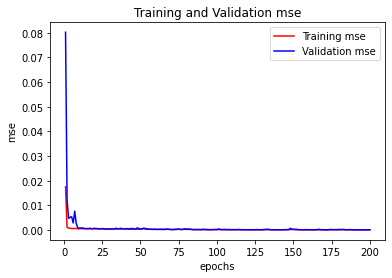

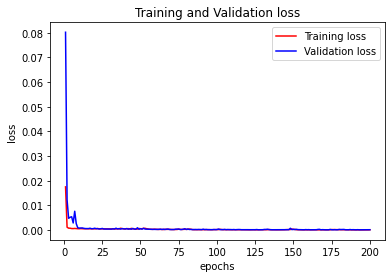

3/3 [==============================] - 0s 8ms/step


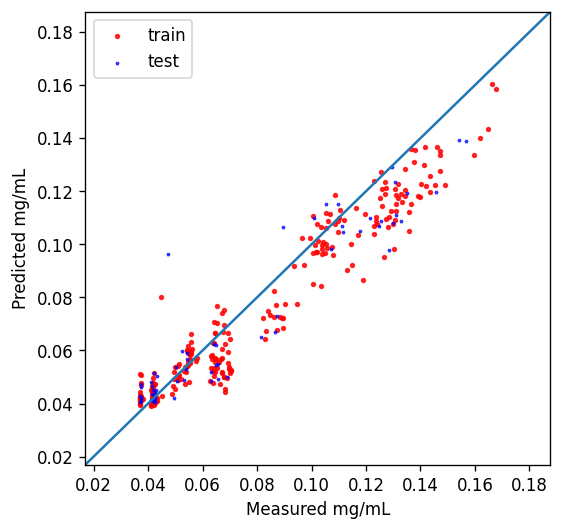

In [62]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_dim=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 1), activation='relu'))
model_cnn.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=40, verbose=1), # 当patience次迭代损失未改善，Keras停止训练
                ]
history_cnn = model_cnn.fit(x_train,y_train,batch_size=50,epochs=200,validation_data=(x_test, y_test),verbose=1,callbacks=callbacks)
model_cnn.save(c+"___"+"cnn.h5")
print(metrics.r2_score(y_test,model_cnn.predict(x_test)))
res.loc[c,'test r2'] = metrics.r2_score(y_test,model_cnn.predict(x_test))
res.loc[c,'tain r2'] = metrics.r2_score(y_train,model_cnn.predict(x_train))
res.loc[c,'test RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_test),y_test))
res.loc[c,'tain RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_train),y_train))
    
plot1(history_cnn,file=c+'______')

y_predictions = model_cnn.predict(x_train)
y_predictions_p = model_cnn.predict(x_test)
plotrealpred(y_train,y_predictions,y_test,y_predictions_p)
plottime(y_train,y_predictions,y_test,y_predictions_p)

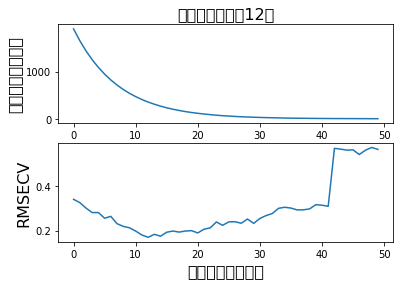

Epoch 1/500
6/6 [==============================] - 1s 117ms/step - loss: 0.7814 - mse: 0.7814 - val_loss: 34.7495 - val_mse: 34.7495
Epoch 2/500
6/6 [==============================] - 0s 60ms/step - loss: 0.5470 - mse: 0.5470 - val_loss: 18.7890 - val_mse: 18.7890
Epoch 3/500
6/6 [==============================] - 0s 51ms/step - loss: 0.4379 - mse: 0.4379 - val_loss: 10.3235 - val_mse: 10.3235
Epoch 4/500
6/6 [==============================] - 0s 55ms/step - loss: 0.4340 - mse: 0.4340 - val_loss: 5.0585 - val_mse: 5.0585
Epoch 5/500
6/6 [==============================] - 0s 48ms/step - loss: 0.3829 - mse: 0.3829 - val_loss: 4.7769 - val_mse: 4.7769
Epoch 6/500
6/6 [==============================] - 0s 55ms/step - loss: 0.3684 - mse: 0.3684 - val_loss: 2.1024 - val_mse: 2.1024
Epoch 7/500
6/6 [==============================] - 0s 56ms/step - loss: 0.3398 - mse: 0.3398 - val_loss: 1.6348 - val_mse: 1.6348
Epoch 8/500
6/6 [==============================] - 0s 50ms/step - loss: 0.3206 - ms

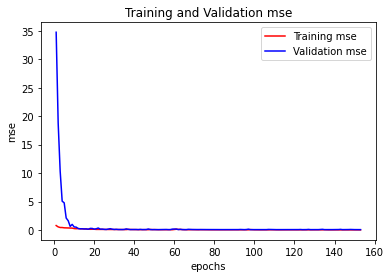

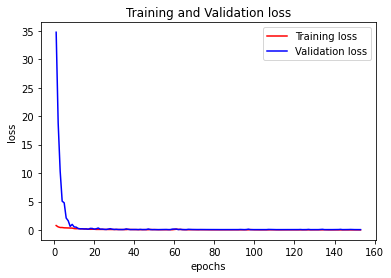

3/3 [==============================] - 0s 8ms/step


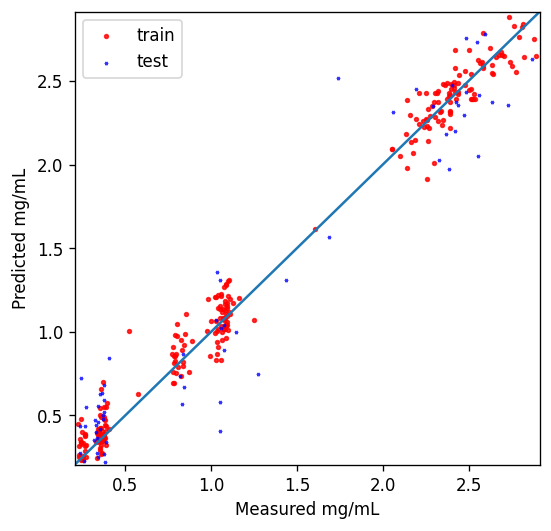

In [63]:
test_size = 0.2
random_state = 1

c = 'DFSB'

import CARS
lis = CARS.CARS_Cloud(np.array(x), np.array(DFSB))
x=np.array(x)
x_=x[:,lis]
x_train, x_test, y_train, y_test = train_test_split(x_, np.array(DFSB), test_size=0.2, random_state=45)
x_train_=np.expand_dims(x_train,2).repeat(2,axis=2)
x_train_=np.expand_dims(x_train_,3)
x_train=x_train_
x_test_=np.expand_dims(x_test,2).repeat(2,axis=2)
x_test_=np.expand_dims(x_test_,3)
x_test=x_test_
y_train_=np.expand_dims(y_train,1)
y_train=y_train_
y_test_=np.expand_dims(y_test,1)
y_test=y_test_
x_train.shape,x_test.shape,y_train.shape,y_test.shape,
    
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_dim=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (3, 1), activation='relu'))
model_cnn.add(Conv2D(32, (8, 1), activation='relu'))
model_cnn.add(Conv2D(64, (8, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=40, verbose=1), # 当patience次迭代损失未改善，Keras停止训练
                ]
history_cnn = model_cnn.fit(x_train,y_train,batch_size=50,epochs=500,validation_data=(x_test, y_test),verbose=1,callbacks=callbacks)
model_cnn.save(c+"___"+"cnn.h5")
print(metrics.r2_score(y_test,model_cnn.predict(x_test)))
res.loc[c,'test r2'] = metrics.r2_score(y_test,model_cnn.predict(x_test))
res.loc[c,'tain r2'] = metrics.r2_score(y_train,model_cnn.predict(x_train))
res.loc[c,'test RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_test),y_test))
res.loc[c,'tain RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_train),y_train))
    
plot1(history_cnn,file=c+'______')

y_predictions = model_cnn.predict(x_train)
y_predictions_p = model_cnn.predict(x_test)
plotrealpred(y_train,y_predictions,y_test,y_predictions_p)
plottime(y_train,y_predictions,y_test,y_predictions_p)

In [64]:
test_size = 0.2
random_state = 1

c = 'Sc'

import CARS
lis = CARS.CARS_Cloud(np.array(x), np.array(Sc))
x=np.array(x)
x_=x[:,lis]
x_train, x_test, y_train, y_test = train_test_split(x_, np.array(Sc), test_size=0.2, random_state=45)
x_train_=np.expand_dims(x_train,2).repeat(2,axis=2)
x_train_=np.expand_dims(x_train_,3)
x_train=x_train_
x_test_=np.expand_dims(x_test,2).repeat(2,axis=2)
x_test_=np.expand_dims(x_test_,3)
x_test=x_test_
y_train_=np.expand_dims(y_train,1)
y_train=y_train_
y_test_=np.expand_dims(y_test,1)
y_test=y_test_
x_train.shape,x_test.shape,y_train.shape,y_test.shape,
    


KeyboardInterrupt: 

Epoch 1/500
6/6 [==============================] - 1s 55ms/step - loss: 1.1092 - mse: 1.1092 - val_loss: 44.4271 - val_mse: 44.4271
Epoch 2/500
6/6 [==============================] - 0s 27ms/step - loss: 0.6487 - mse: 0.6487 - val_loss: 22.9875 - val_mse: 22.9875
Epoch 3/500
6/6 [==============================] - 0s 29ms/step - loss: 0.3998 - mse: 0.3998 - val_loss: 7.9664 - val_mse: 7.9664
Epoch 4/500
6/6 [==============================] - 0s 32ms/step - loss: 0.4001 - mse: 0.4001 - val_loss: 6.4035 - val_mse: 6.4035
Epoch 5/500
6/6 [==============================] - 0s 30ms/step - loss: 0.3632 - mse: 0.3632 - val_loss: 5.9531 - val_mse: 5.9531
Epoch 6/500
6/6 [==============================] - 0s 27ms/step - loss: 0.3884 - mse: 0.3884 - val_loss: 4.2106 - val_mse: 4.2106
Epoch 7/500
6/6 [==============================] - 0s 27ms/step - loss: 0.3649 - mse: 0.3649 - val_loss: 2.4713 - val_mse: 2.4713
Epoch 8/500
6/6 [==============================] - 0s 27ms/step - loss: 0.3450 - mse: 

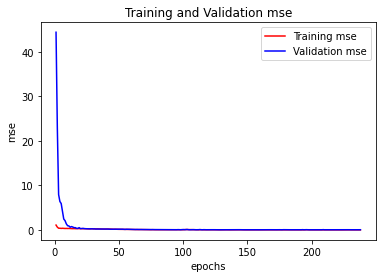

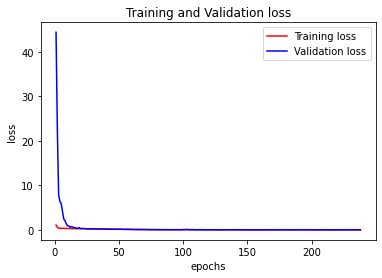

3/3 [==============================] - 0s 5ms/step


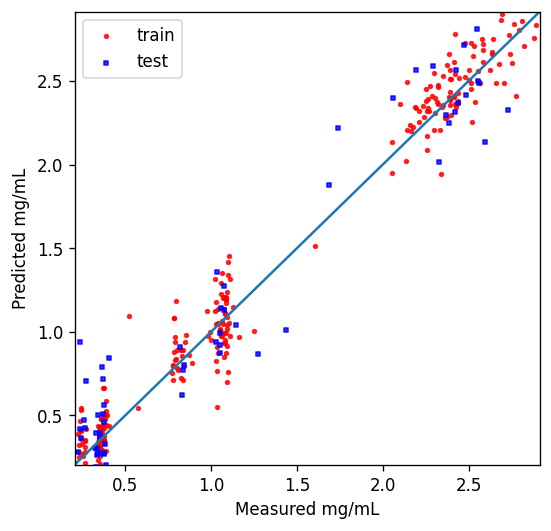

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3, 1), activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(BatchNormalization(input_dim=(x_train.shape[1],x_train.shape[2],1)))
model_cnn.add(MaxPooling2D((2,1)))
#     model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(16, (8, 1), activation='relu'))
model_cnn.add(Conv2D(32, (8, 1), activation='relu'))
model_cnn.add(Conv2D(64, (8, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-4),metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=40, verbose=1), # 当patience次迭代损失未改善，Keras停止训练
                ]
history_cnn = model_cnn.fit(x_train,y_train,batch_size=50,epochs=500,validation_data=(x_test, y_test),verbose=1,callbacks=callbacks)
model_cnn.save(c+"___"+"cnn.h5")
print(metrics.r2_score(y_test,model_cnn.predict(x_test)))
res.loc[c,'test r2'] = metrics.r2_score(y_test,model_cnn.predict(x_test))
res.loc[c,'tain r2'] = metrics.r2_score(y_train,model_cnn.predict(x_train))
res.loc[c,'test RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_test),y_test))
res.loc[c,'tain RMSE'] = np.sqrt(metrics.mean_squared_error(model_cnn.predict(x_train),y_train))
    
plot1(history_cnn,file=c+'______')

y_predictions = model_cnn.predict(x_train)
y_predictions_p = model_cnn.predict(x_test)
plotrealpred(y_train,y_predictions,y_test,y_predictions_p)
plottime(y_train,y_predictions,y_test,y_predictions_p)


In [ ]:
res

tain r2   test r2  tain RMSE  test RMSE
DSS   0.979186  0.856340   0.003387   0.009031
AWS   0.990965  0.726443   0.001418   0.008071
MDXS  0.987990  0.827896   0.004028   0.015445
DFSB  0.974038  0.927289   0.144546   0.248276
Sc    0.000000  0.000000   0.000000   0.000000